<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S15/ResUnet_Model_SSIM_ADAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun  9 07:23:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Dataset')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Dataset')

In [0]:
#!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git

Cloning into 'pytorch-ssim'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [0]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=3)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64

In [0]:
rm -r '/content/data/'

rm: cannot remove '/content/data/': No such file or directory


In [6]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z' -o'/content/data/bg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/fgbg.7z' -o'/content/data/fgbg/'
!7z x '/content/gdrive/My Drive/Colab Notebooks/Dataset/Densedepth.7z' -o'/content/data/Densedepth/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/Dataset/                                                           1 file, 2286969 bytes (2234 KiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
--
Path = /content/gdrive/My Drive/Colab Notebooks/Dataset/bg.7z
Type = 7z
Physical Size = 2286969
Headers Size = 1341
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 100
Size:       2341905
Compressed: 2286969

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (30

In [0]:
bg_image_list_final=[]
fgbg_image_list=[]
bg_image_list=[]
mask_image_list=[]
depth_image_list=[]

count=1  # to restrict the data to few thousand


# Getting the BG list and replicate each background to 4000 


for root, dirs, files in os.walk("/content/data/bg/"):
   for name in files:
      if count == 10:
       break
      bg_image_list.append(root+name)
      bg_image_list_final=(((bg_image_list)*4000)+bg_image_list_final)
      fgbg_folder=(name.split('.'))[0]
      bg_image_list=[]
      count = count + 1
      

# Getting the fgbg list into Variable for data loader.

      path="/content/data/fgbg/" + fgbg_folder
  
      for root_fgbg, dirs_fgbg, files_fgbg in os.walk(path):
          for name_fgbg in files_fgbg:
             fgbg_image_list.append(root_fgbg +'/'+ name_fgbg)

# Getting the mask list into Variable for data loader.

      path="/content/data/Densedepth/" + fgbg_folder

      for root_depth, dirs_depth, files_depth in os.walk(path):
          for name_depth in files_depth:
             depth_image_list.append(root_depth +'/'+ name_depth)
 

In [8]:
fgbg_image_dataset=sorted(fgbg_image_list)
bg_image_dataset=sorted(bg_image_list_final)
depth_image_dataset=sorted(depth_image_list)
print('No of data in fgbg list:',   len(fgbg_image_dataset))
print('No of data in bg list:' ,    len(bg_image_dataset))
print('No of image in depth image:', len(depth_image_dataset))

No of data in fgbg list: 36000
No of data in bg list: 36000
No of image in depth image: 36000


In [0]:

fgbg_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ColorJitter(brightness=0.50, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10,10),fill=(0)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       #transforms.Normalize((0.49641467,), (0.2798614 ,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

bg_transform = transforms.Compose([
                                       transforms.Resize((128, 128)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10,10),fill=(0)),
                                       transforms.Grayscale(),
                                       transforms.ToTensor(),
                                       
                                       #transforms.Normalize((0.49836101,), (0.27918635,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


depth_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.Grayscale(num_output_channels=3),
                                       #transforms.ColorJitter(brightness=0.50, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-10,10),fill=(0,)),
                                       transforms.ToTensor(),
                                       
                                       #transforms.Normalize((0.05250582,), (0.22033702,))
                                       ])

In [0]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [0]:
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,bg_image_dataset,fgbg_image_dataset,depth_image_dataset,transform=None):
       #super(depthmask, self).__init__()
       self.bg_image_dataset = bg_image_dataset
       
       self.fgbg_image_dataset = fgbg_image_dataset
       self.depth_image_dataset = depth_image_dataset
       self.transform = transform
       

    def __getitem__ (self, idx): 
         bg = Image.open(self.bg_image_dataset[idx])
         fgbg = Image.open(self.fgbg_image_dataset[idx])
         depth = Image.open(self.depth_image_dataset[idx])
         if self.transform:
           bg = self.transform[1](bg)
           fgbg = self.transform[0](fgbg)
           depth = self.transform[2](depth)
           sample = {'bg' : bg, 'fgbg': fgbg, 'depth': depth}
         return sample
    
    def __len__ (self):
       return len(self.fgbg_image_dataset)
  

In [12]:
final_dataset=Myclass(bg_image_dataset,fgbg_image_dataset,depth_image_dataset,transform=[fgbg_transform,bg_transform,depth_transform])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-BG:', sample['bg'].size(),'-FGBG:' ,sample['fgbg'].size(),'-depth' ,sample['depth'].size())

    if i == 3:
        break

0 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([3, 224, 224]) -depth torch.Size([3, 224, 224])
1 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([3, 224, 224]) -depth torch.Size([3, 224, 224])
2 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([3, 224, 224]) -depth torch.Size([3, 224, 224])
3 -BG: torch.Size([1, 128, 128]) -FGBG: torch.Size([3, 224, 224]) -depth torch.Size([3, 224, 224])


In [13]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 

train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (28000, 8000))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                         shuffle=False, num_workers=2)

CUDA Available? True


In [0]:
img=next(iter(trainloader))

In [0]:
from tqdm import tqdm
from math import log10
import numpy as np

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  #cri = nn.MSELoss()                 # Regression loss
  #cri1 = nn.BCEWithLogitsLoss()       # Pixel Confidence 
  #cri=pytorch_ssim.ssim()
  for batch_idx, data in enumerate(pbar):
    # get samples
    data['bg'] = data['bg'].to(device)
    data['fgbg'] = data['fgbg'].to(device)
    data['depth'] = data['depth'].to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    y_pred = model(data['fgbg'])
   
    # Calculate loss
    
    #loss=cri(y_pred,data['depth'])
    loss =1 - ssim(y_pred,data['depth'],data_range=1.0, size_average=True)
    #ssim_loss = pytorch_ssim.SSIM()
    #loss =  - ssim_loss(data['depth'],y_pred)
    #ssim_value = - loss.data[0]

    #loss_con=cri1(y_pred,data['depth'])
    train_losses.append(loss)
    #loss=loss_reg+loss_con
    # Backpropagation
    loss.backward()    
    optimizer.step()

    # Update pbar-tqdm
    
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    #correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx}')
    #train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    map=[]
    test_loss = 0
    correct = 0
    avg_psnr = 0
    #cri = nn.MSELoss()
    #cri1 = nn.BCEWithLogitsLoss()       # Pixel Confidence 
    #cri=pytorch_ssim.ssim()
    with torch.no_grad():
        for data in test_loader:
            data['bg'] = data['bg'].to(device)
            data['fgbg'] = data['fgbg'].to(device)
            data['depth'] = data['depth'].to(device)

            output = model(data['fgbg'])
            test_loss +=1 - ssim(output,data['depth'],data_range=1.0, size_average=True)
            #ssim_loss = pytorch_ssim.SSIM()
            #test_loss = ssim_loss(data['depth'],output)
            #ssim_value =  test_loss.item()
            #ssim_out = -ssim_loss(output,data['depth'] )
            #ssim_value = - ssim_out.data[0]
            #bce = cri1(output, data['depth'])
            #loss=mse+bce
            #psnr = 20 * log10(255 / loss.item())
            #avg_psnr += psnr
              
    #print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_loader.dataset)))
           
#            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#            correct += pred.eq(target.view_as(pred)).sum().item()
    
    #plt.imshow(np.transpose((output[14]).cpu().detach().numpy(), (1,2, 0)))
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    
#        100. * correct / len(test_loader.dataset)))
    
#    test_acc.append(100. * correct / len(test_loader.dataset))
  
   

In [15]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

In [16]:
from torch.optim.lr_scheduler import StepLR
import pytorch_ssim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.90,weight_decay=0.001)
optimizer=optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
scheduler=StepLR(optimizer,step_size=3,gamma=0.1)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

  0%|          | 0/1750 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0237

EPOCH: 1


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0038

EPOCH: 2


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0034

EPOCH: 3


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0029

EPOCH: 4


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0029

EPOCH: 5


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0028

EPOCH: 6


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0027

EPOCH: 7


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0027

EPOCH: 8


  0%|          | 0/1750 [00:00<?, ?it/s]


Test set: Average loss: 0.0027

EPOCH: 9


Loss=0.033421993255615234 Batch_id=1749: 100%|██████████| 1750/1750 [07:14<00:00,  4.03it/s]



Test set: Average loss: 0.0027



In [17]:
data=(next(iter(testloader)))
out=model(data['fgbg'].to(device))
data1=(next(iter(trainloader)))

out[7]

tensor([[[0.3858, 0.4960, 0.5787,  ..., 0.4906, 0.4064, 0.2489],
         [0.5609, 0.6205, 0.6225,  ..., 0.4579, 0.4272, 0.2329],
         [0.6707, 0.6618, 0.6152,  ..., 0.4546, 0.4367, 0.3569],
         ...,
         [0.1085, 0.1045, 0.0916,  ..., 0.0270, 0.0282, 0.0613],
         [0.1056, 0.1244, 0.1123,  ..., 0.0364, 0.0419, 0.0505],
         [0.1150, 0.1559, 0.1381,  ..., 0.0377, 0.0338, 0.0478]],

        [[0.4830, 0.5751, 0.5918,  ..., 0.4779, 0.4648, 0.2440],
         [0.5725, 0.6193, 0.6204,  ..., 0.4578, 0.4312, 0.2795],
         [0.6696, 0.6615, 0.6144,  ..., 0.4550, 0.4361, 0.3694],
         ...,
         [0.1094, 0.1059, 0.0918,  ..., 0.0267, 0.0277, 0.0661],
         [0.1012, 0.1227, 0.1125,  ..., 0.0348, 0.0229, 0.0428],
         [0.0883, 0.1567, 0.1405,  ..., 0.0436, 0.0414, 0.0266]],

        [[0.4515, 0.5442, 0.5863,  ..., 0.4700, 0.4047, 0.2304],
         [0.6129, 0.6239, 0.6222,  ..., 0.4581, 0.4304, 0.2625],
         [0.6783, 0.6617, 0.6154,  ..., 0.4545, 0.4321, 0.

In [18]:
data['depth'][7]

tensor([[[0.6157, 0.5961, 0.5804,  ..., 0.4471, 0.4431, 0.4392],
         [0.6118, 0.5961, 0.5804,  ..., 0.4510, 0.4471, 0.4471],
         [0.6157, 0.5961, 0.5804,  ..., 0.4588, 0.4549, 0.4549],
         ...,
         [0.1137, 0.1059, 0.0980,  ..., 0.0392, 0.0549, 0.0667],
         [0.1255, 0.1176, 0.1098,  ..., 0.0471, 0.0627, 0.0745],
         [0.1333, 0.1294, 0.1216,  ..., 0.0510, 0.0667, 0.0784]],

        [[0.6157, 0.5961, 0.5804,  ..., 0.4471, 0.4431, 0.4392],
         [0.6118, 0.5961, 0.5804,  ..., 0.4510, 0.4471, 0.4471],
         [0.6157, 0.5961, 0.5804,  ..., 0.4588, 0.4549, 0.4549],
         ...,
         [0.1137, 0.1059, 0.0980,  ..., 0.0392, 0.0549, 0.0667],
         [0.1255, 0.1176, 0.1098,  ..., 0.0471, 0.0627, 0.0745],
         [0.1333, 0.1294, 0.1216,  ..., 0.0510, 0.0667, 0.0784]],

        [[0.6157, 0.5961, 0.5804,  ..., 0.4471, 0.4431, 0.4392],
         [0.6118, 0.5961, 0.5804,  ..., 0.4510, 0.4471, 0.4471],
         [0.6157, 0.5961, 0.5804,  ..., 0.4588, 0.4549, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


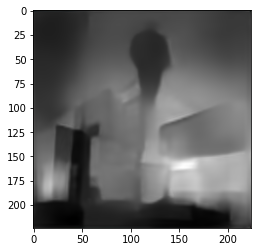

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.transpose((out[13]).cpu().detach().numpy(), (1,2, 0)))

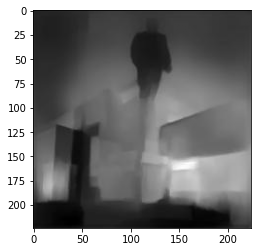

In [24]:
plt.imshow(np.transpose((data['depth'][13]).cpu().detach().numpy(), (1,2,0)))

In [0]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


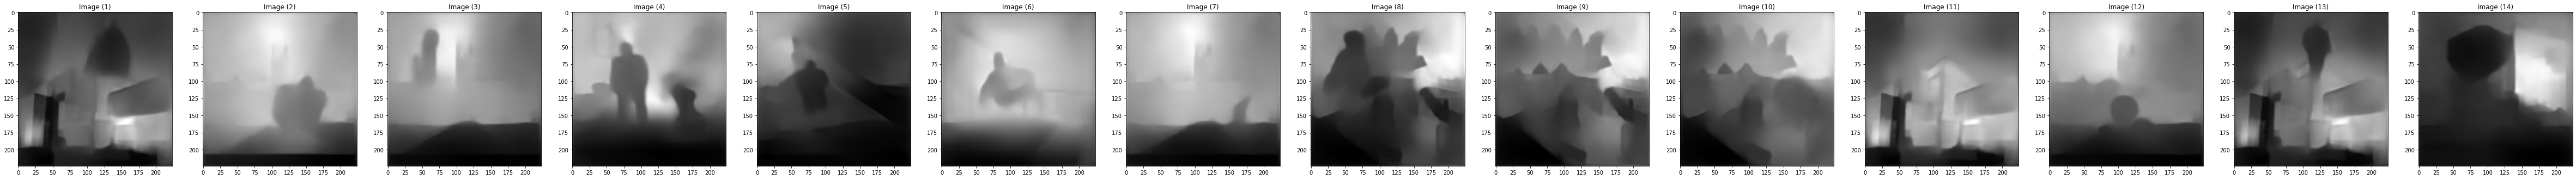

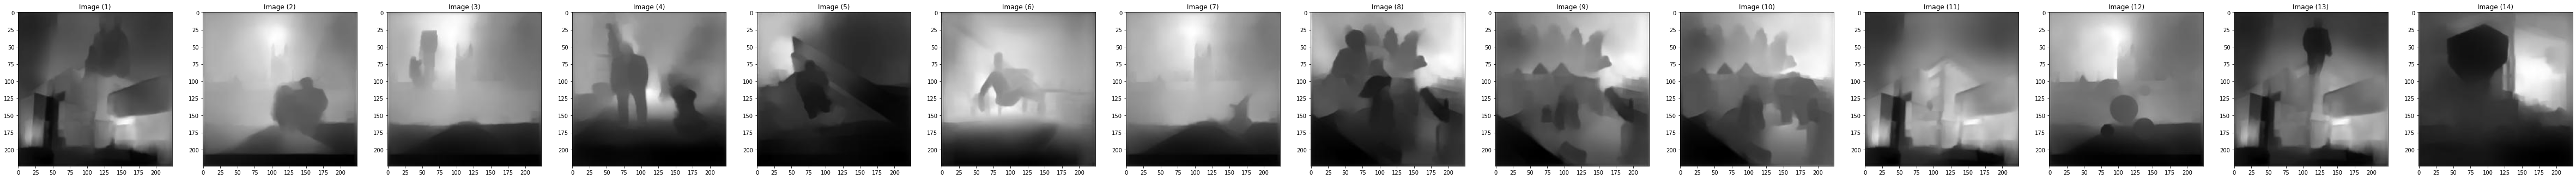

In [28]:
a,b,c,d=out.shape
images_out=[]
images_in=[]
images_out1=[]
images_in1=[]
for i in range(1,15):
  images_out.append(np.transpose(out[i].cpu().detach().numpy(),(1,2,0)))
  images_in.append(np.transpose(data['depth'][i].cpu().detach().numpy(),(1,2,0)))
show_images(images_out)
show_images(images_in)